# Playground Series - Season 3, Episode 11

## Load Competition Items

In [25]:
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# set style
sns.set_palette('deep')
cp = sns.color_palette('deep')

In [3]:
# specify path and load data
data_path = Path('../data')
test_df = pd.read_csv(data_path/'test.csv')
train_df = pd.read_csv(data_path/'train.csv')
samp_submission = pd.read_csv(data_path/'sample_submission.csv')

## Data Understanding

In [4]:
# examine beginning and end of training data
display(train_df.head(3))
display(train_df.tail(3))

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51


,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
360333,360333,10.74,3.0,0.0,0.0,2.0,11.3,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,360334,11.04,3.0,1.0,0.0,3.0,10.2,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72
360335,360335,5.30,2.0,2.0,0.0,2.0,10.8,0.0,0.0,21.0,33858.0,1.0,0.0,1.0,1.0,1.0,122.47


In [5]:
# training data information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [6]:
# rename some columns to assist with workflow efficiency
train_df = train_df.rename(columns={'store_sales(in millions)':'store_sales',
                                    'unit_sales(in millions)': 'unit_sales',
                                    'avg_cars_at home(approx).1': 'avg_cars_at_home'})

test_df = test_df.rename(columns={'store_sales(in millions)':'store_sales',
                                    'unit_sales(in millions)': 'unit_sales',
                                    'avg_cars_at home(approx).1': 'avg_cars_at_home'})

`cost` is the target variable.

### Variable Distributions

#### Target

In [7]:
# identify target
target = train_df[['cost']]

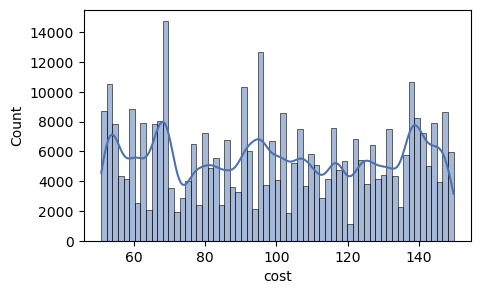

In [8]:
# target 
plt.figure(figsize=(5,3))
sns.histplot(x=train_df.cost,kde=True)
plt.show()

#### Predictors

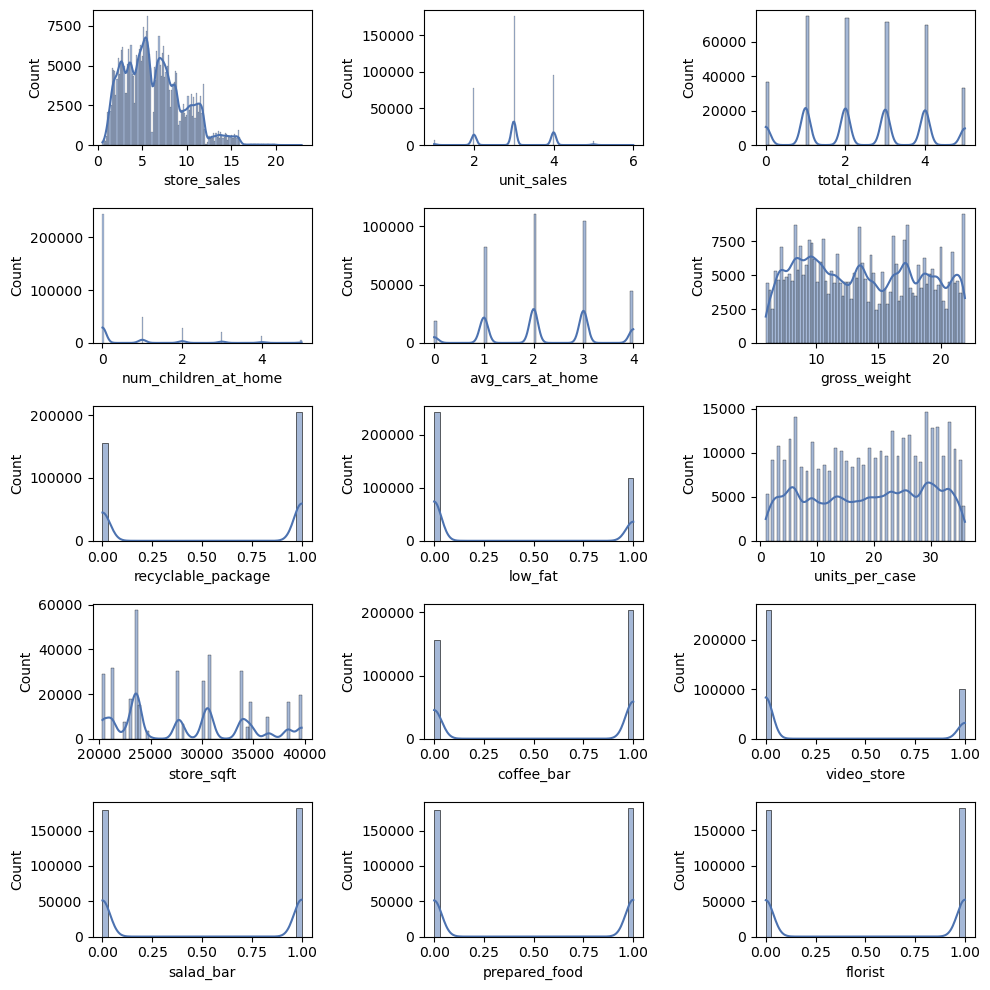

In [9]:
# set up subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,10))
feat_cols = train_df.drop(['cost', 'id'], axis=1).columns

for feat, ax in zip(feat_cols, axes.flatten()):
    sns.histplot(train_df[feat], kde=True, bins='auto', ax=ax)
    ax.set_xlabel(feat)
plt.tight_layout()
plt.show()

In [10]:
# print unique vals in each column
for feat in feat_cols:
    print(f'\n{feat}')
    print(train_df[feat].value_counts())
    print('--------------------------------')


store_sales
5.04     2373
5.40     1988
7.41     1919
7.95     1874
5.52     1831
         ... 
3.79        1
5.45        1
16.15       1
2.02        1
5.77        1
Name: store_sales, Length: 1044, dtype: int64
--------------------------------

unit_sales
3.0    175556
4.0     94999
2.0     77240
1.0      6765
5.0      5745
6.0        31
Name: unit_sales, dtype: int64
--------------------------------

total_children
1.0    74857
2.0    73902
3.0    71524
4.0    70134
0.0    36441
5.0    33478
Name: total_children, dtype: int64
--------------------------------

num_children_at_home
0.0    243555
1.0     49427
2.0     28163
3.0     20382
4.0     12532
5.0      6277
Name: num_children_at_home, dtype: int64
--------------------------------

avg_cars_at_home
2.0    110401
3.0    104424
1.0     82619
4.0     44355
0.0     18537
Name: avg_cars_at_home, dtype: int64
--------------------------------

gross_weight
17.10    4372
14.70    3906
19.90    3800
17.20    3616
13.70    3516
         .

In [11]:
# identify continuous and categorical columns
cat_cols = ['total_children', 'num_children_at_home',
             'avg_cars_at_home', 'recyclable_package', 'low_fat',
             'coffee_bar', 'video_store', 'salad_bar', 
             'prepared_food', 'florist', 'unit_sales']
cont_cols = ['store_sales', 'gross_weight', 'units_per_case', 'store_sqft']

For the time being, categorical features with clear ordinal relationships will be considered as continuous, including:
- `unit_sales(in millions)`
- `store_sqft`

### Analyze Impact of Predictors on Target

#### Categorical Predictors

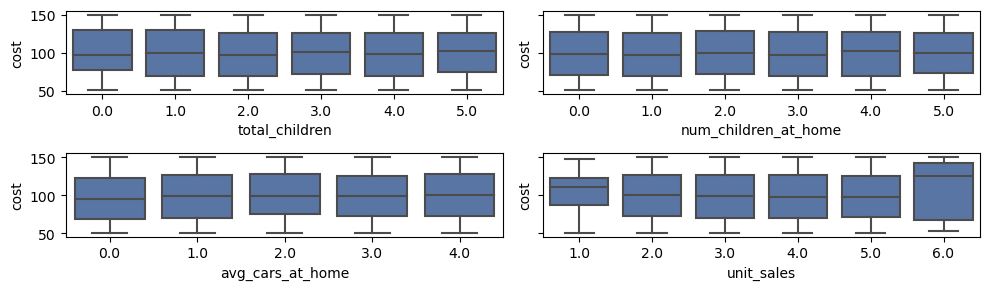

In [12]:
# children and cars 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,3), sharey=True)
for feat, ax in zip(['total_children', 'num_children_at_home', 'avg_cars_at_home', 'unit_sales'],
                    axes.flatten()):
    sns.boxplot(x=train_df[feat], y=train_df.cost, color=cp[0], ax=ax)
plt.tight_layout()
plt.show()

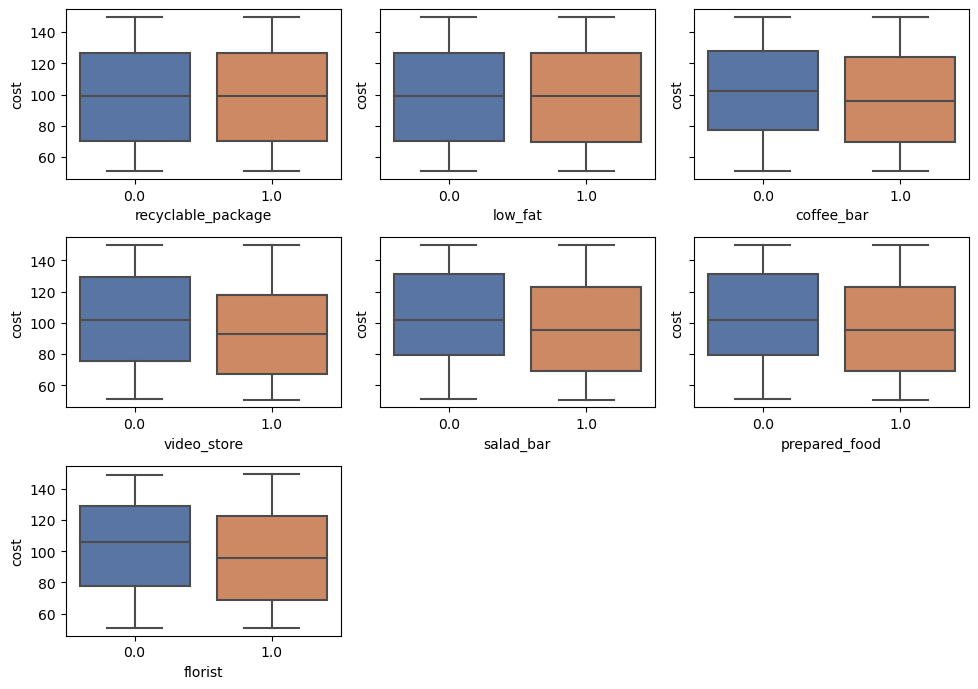

In [13]:
# binary predictors
multi_class_cat = ['total_children', 'num_children_at_home', 'avg_cars_at_home']
binary_predictors = [x for x in cat_cols if x not in multi_class_cat]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 7), sharey=True)
for feat, ax in zip(binary_predictors, axes.flatten()):
    sns.boxplot(x=train_df[feat], y=train_df.cost, ax=ax)
plt.tight_layout()

# delete empty subplots
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])
plt.show()

#### Continous Predictors

In [14]:
cont_cols

['store_sales', 'gross_weight', 'units_per_case', 'store_sqft']

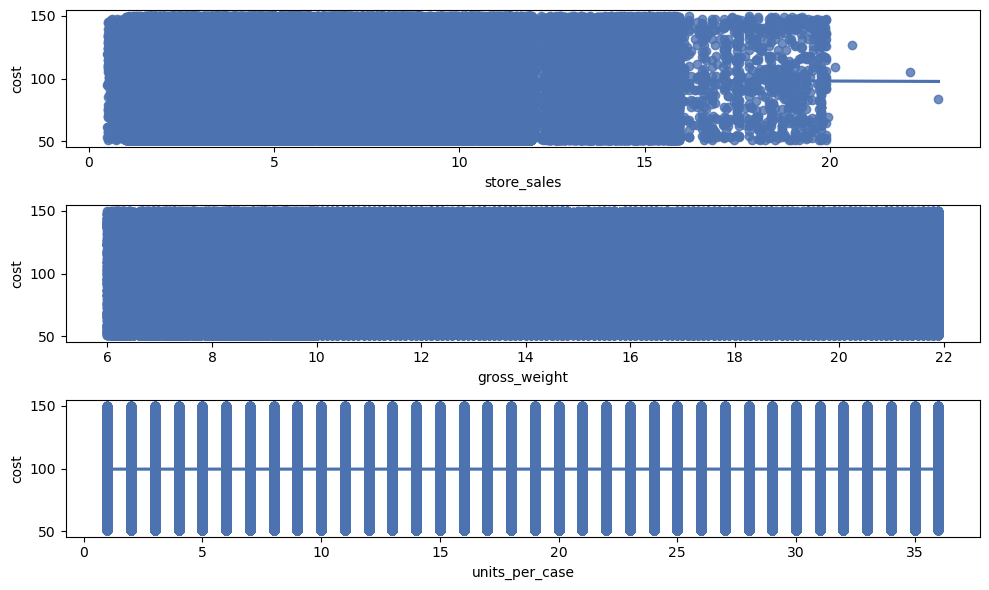

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharey=True)
for feat, ax in zip(cont_cols, axes.flatten()):
    sns.regplot(x=train_df[feat], y=train_df.cost, ax=ax, ci=None)
plt.tight_layout()
plt.show()

We can see some clear relationships within the categorical variables, but continuous variables are not showing much relationship. 

## Data Preparation

In [16]:
# check for missing values and duplicates
print(f'{train_df.isna().sum().sum()} missing values')
print(f'{train_df.duplicated().sum()} duplicates')

0 missing values
0 duplicates


In [17]:
# split into X and y
y = train_df['cost']
X = train_df.drop(['cost', 'id'], axis=1)

In [18]:
# create validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [19]:
# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

In [20]:
# save final versions of training and validation sets
X_train_final = X_train_scaled.copy()
X_val_final = X_val_scaled.copy()
y_train_final = y_train.copy()
y_val_final = y_val.copy()

## Modeling

In [21]:
# baseline model
xgb_baseline = XGBRegressor(random_state=23)
xgb_baseline.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=23, ...)

In [33]:
# print training score
score = xgb_baseline.score(X_train_final, y_train_final)
print(f'Training score: {score}')

# print testing score
score = xgb_baseline.score(X_val_final, y_val_final)
print(f'Testing score: {score}')

Training score: 0.1394777836206017
Testing score: 0.10698203139653073


In [34]:
# check RMSE
y_test_preds = xgb_baseline.predict(X_val_final)
mse = mean_squared_error(y_val_final, y_test_preds)
rmse = mse ** (1/2.0)
print(rmse)

28.361966331259303


## Submissions